# 5. Custom Neural Network for Tabular Data

### [2024.02.28] 이상혁

### 개요
- IDA 2016 Challenge에서 진행한 APS Failure and Operational Data for Scania Trucks 데이터를 이용하여, 결측치와 피쳐 수가 많은 데이터에 대한 이진 분류
- 한번 접해본 적이 있는 데이터지만, 시각화/결측치 보간/파생변수 생성 그리고 Neural Network를 활용한 모델링을 진행

### 1. Libraries

In [1]:
# os 충돌 방지

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# 디렉토리 설정
dir = '5. Custom Neural Network for Tabular Data'
path = 'C:/Python_Programs/Pytorch/' + dir
os.chdir(path)
print(path)

C:/Python_Programs/Pytorch/5. Custom Neural Network for Tabular Data


In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import time
import datetime
import random
import re
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from tqdm import tqdm

import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchsummary import summary
from torchmetrics import Metric
from torchmetrics.classification import BinaryF1Score, BinaryAccuracy

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
# 시드 고정
def fixSEED(seed, deterministic=True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

fixSEED(seed=42)

### 2. EDA

In [87]:
# 데이터 불러오기
train = pd.read_csv('training_set.csv', encoding='utf-8-sig')
test = pd.read_csv('test_set.csv', encoding='utf-8-sig')

In [7]:
# 데이터 기본 정보 확인
print('--------Train data 기본 정보---------')
print('{}개의 행과 {}개의 열이 있습니다.'.format(train.shape[0], train.shape[1]))
print()
print('--------Train data 데이터 타입---------')
print(train.dtypes.unique())

--------Train data 기본 정보---------
55000개의 행과 172개의 열이 있습니다.

--------Train data 데이터 타입---------
[dtype('O') dtype('int64') dtype('float64')]


In [246]:
# 데이터 한번 보기
train.head(3)

,ID_code,class,X1,X2,X3,X4,X5,X6,X7a,X7b,...,X105c,X105d,X105e,X105f,X105g,X105h,X105i,X105j,X106,X107
0,train_1,0,3490,0.0,80.0,212.0,0.0,0.0,0.0,0.0,...,12986.0,7612.0,17044.0,13682.0,19594.0,74564.0,5270.0,0.0,0.0,0.0
1,train_2,0,92,0.0,14.0,10.0,0.0,0.0,0.0,0.0,...,512.0,120.0,332.0,344.0,964.0,1414.0,0.0,0.0,0.0,0.0
2,train_3,0,10,0.0,18.0,2.0,4.0,6.0,0.0,0.0,...,132.0,22.0,32.0,24.0,26.0,54.0,0.0,0.0,0.0,0.0


In [88]:
# ID_code 열 삭제
train.drop(['ID_code'], axis=1, inplace=True)
test.drop(['ID_code'], axis=1, inplace=True)

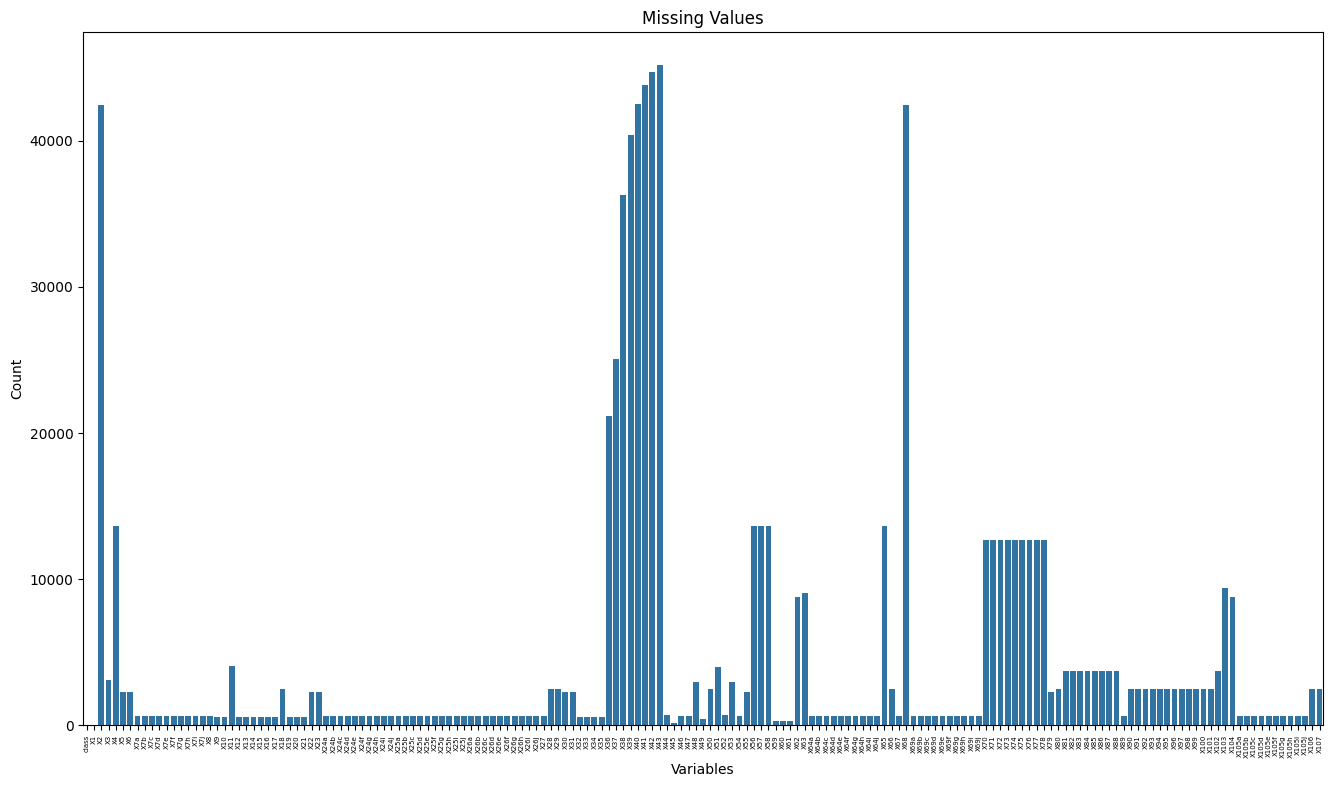

In [248]:
# 결측치 확인
train_missing = train.isna().sum()

plt.figure(figsize=(16,9))
sns.barplot(train_missing)
plt.title('Missing Values')
plt.xlabel('Variables')
plt.ylabel('Count')
plt.xticks(rotation=90, fontsize=5)
plt.show()

- 결측치가 매우 많다.
- 따라서 **결측치가 대부분인 변수는 삭제**하는 것이 좋을 것 같다.
- **결측치 보간** 또한 매우 중요하다.

In [9]:
# 결측치 비율 확인
def missing_percentage(column, threshold):
    rows_missing = column.isna().sum()
    rows = len(column)
    percentage = rows_missing/rows * 100

    if percentage >= threshold:
        print('{}열의 결측치 개수는 {}개이고, 비율은 {:.4f}입니다.'.format(column.name, rows_missing, percentage))

    return percentage

In [10]:
# 결측치 70% 이상인 변수 확인
train.apply(lambda x: missing_percentage(x, threshold=70), axis=0)

X2열의 결측치 개수는 42415개이고, 비율은 77.1182입니다.
X39열의 결측치 개수는 40365개이고, 비율은 73.3909입니다.
X40열의 결측치 개수는 42482개이고, 비율은 77.2400입니다.
X41열의 결측치 개수는 43766개이고, 비율은 79.5745입니다.
X42열의 결측치 개수는 44660개이고, 비율은 81.2000입니다.
X43열의 결측치 개수는 45161개이고, 비율은 82.1109입니다.
X68열의 결측치 개수는 42415개이고, 비율은 77.1182입니다.


class     0.000000
X1        0.000000
X2       77.118182
X3        5.565455
X4       24.720000
           ...    
X105h     1.109091
X105i     1.109091
X105j     1.109091
X106      4.516364
X107      4.514545
Length: 171, dtype: float64

- 70% 이상인 열은 지우도록 해야겠다.

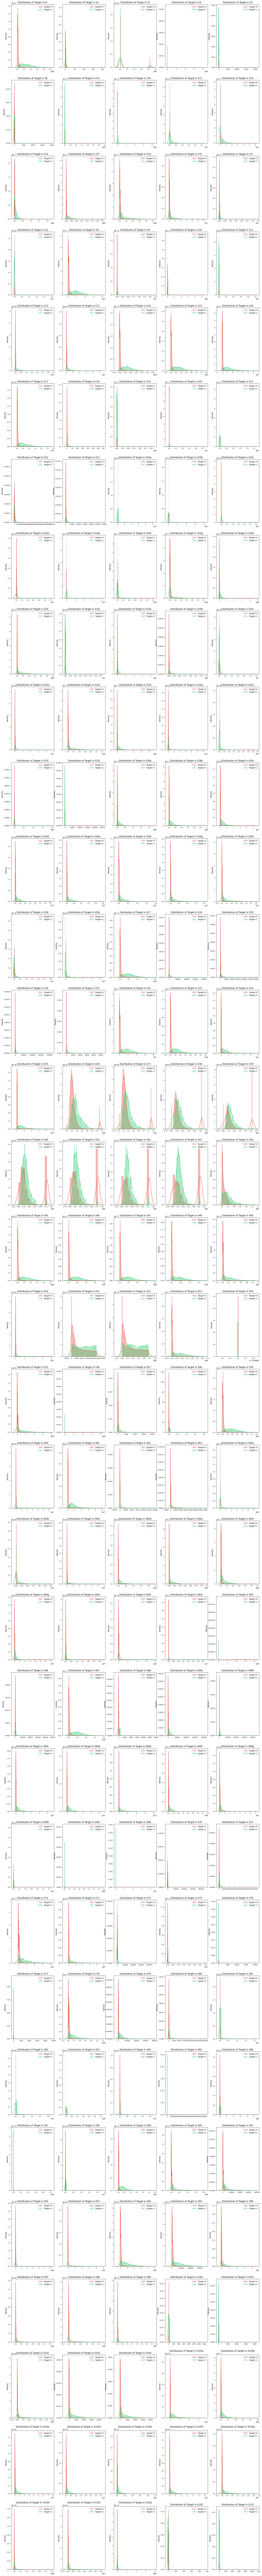

CPU times: total: 2min 29s
Wall time: 1min 23s


In [251]:
%%time

# 변수별 분포 시각화
features = train.drop(['class'], axis=1).columns.tolist()

nrows = 50
fig, axs = plt.subplots(nrows=34, ncols=5, figsize=(24, nrows * 5))

for i, feature in enumerate(features, 1):
    plt.subplot(34, 5, i)

    sns.distplot((train[train['class'] == 0][feature].values), label='Target=0', hist=True, color='#e74c3c')
    sns.distplot((train[train['class'] == 1][feature].values), label='Target=1', hist=True, color='#2ecc71')

    plt.tick_params(axis='x', which='major', labelsize=8)
    plt.tick_params(axis='y', which='major', labelsize=8)

    plt.legend(loc='upper right')
    plt.xlabel('')
    plt.title('Distribution of Target in {}'.format(feature))

plt.show()

- 대부분의 변수에서 이상치가 나타나고 있다. 
- box-cox 변환을 시도해봐야겠다.
- 이상치 여부를 isolation forest로 판단하고 파생변수를 만들 수도 있다.

CPU times: total: 1min 45s
Wall time: 1min 50s


Text(0.5, 1.0, 'Correlation of Variables')

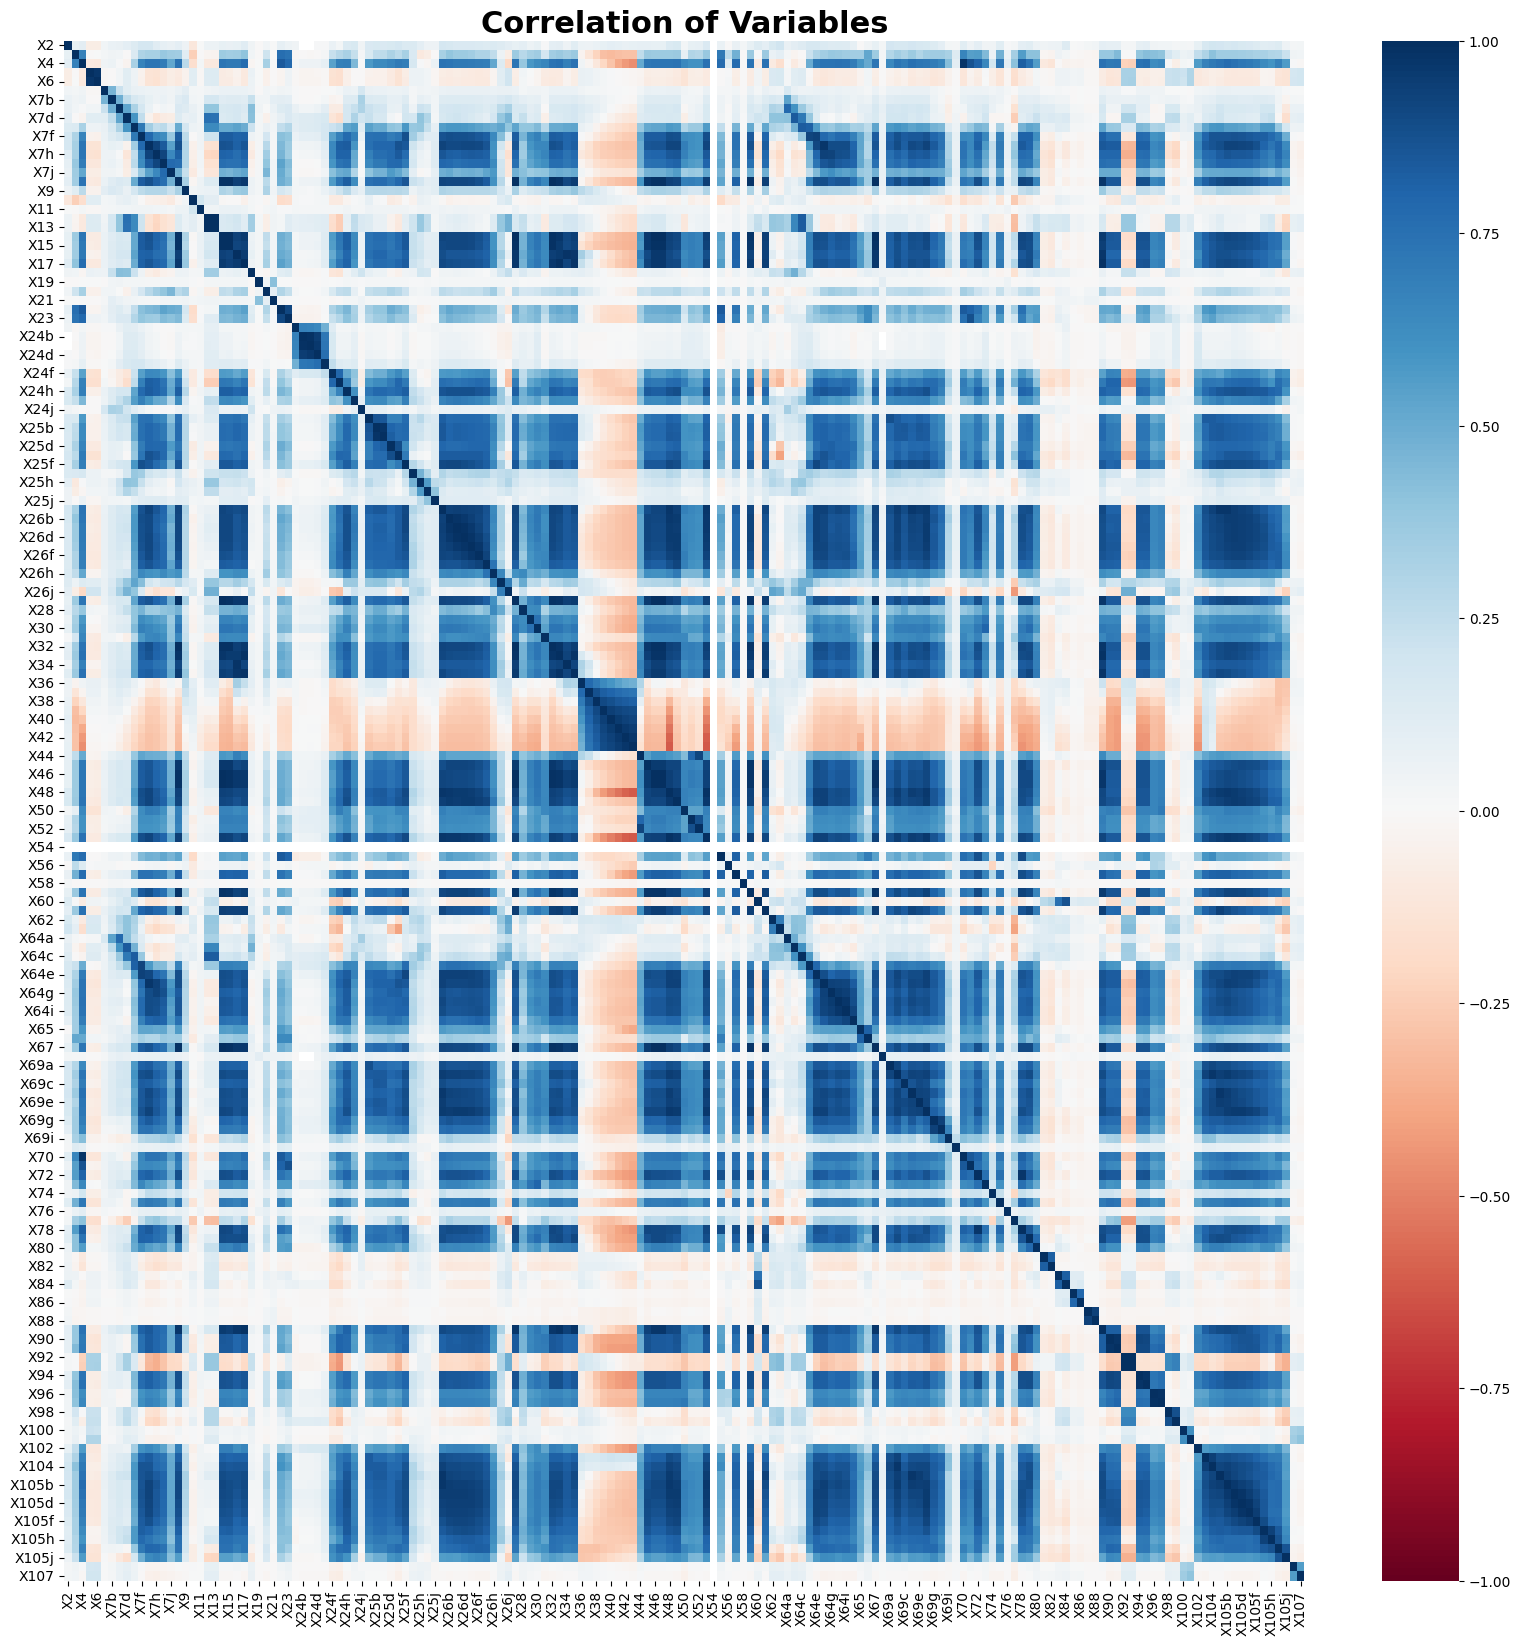

In [14]:
%%time

# 변수 상관관계 시각화
num_var = train.select_dtypes(include = ['float64'])
num_corr = num_var.corr(method='spearman') # 이상치가 많기 때문에 스피어만 상관계수 계산

plt.figure(figsize=(20, 20), dpi=100)
sns.heatmap(num_corr, annot=False, cmap='RdBu', vmin=-1, vmax=1, center=0)
plt.title("Correlation of Variables", fontweight="bold", fontsize = 22)

- 많은 변수에서 상관관계가 강하게 나타나고 있고, 음의 상관관계가 나타나는 변수도 있다.

### 3. Pre-process

#### (1) 결측치 20% 이상인 열 제거

In [89]:
# 결측치 20% 이상인 열 제거
missing_drop_var = ['X2', 'X39', 'X40', 'X41', 'X42', 'X43', 'X68']

train.drop(columns=missing_drop_var, axis=1, inplace=True)
test.drop(columns=missing_drop_var, axis=1, inplace=True)

print(train.shape[1])

164


#### (2) 결측치 보간

- 결측치가 많이 발생하는 변수는 삭제해줬다.
- 따라서 KNN 등의 방법이 아닌 **중앙값**으로 결측치를 보간해준다.

In [90]:
# train data
for var in train.columns:
    if train[var].isna().sum() != 0:
        train[var][train[var].isna()] = train[var].median()

# test data
for var in test.columns:
    if test[var].isna().sum() != 0:
        test[var][test[var].isna()] = test[var].median()

In [91]:
# 결측치 확인
train.isna().sum()

class    0
X1       0
X3       0
X4       0
X5       0
        ..
X105h    0
X105i    0
X105j    0
X106     0
X107     0
Length: 164, dtype: int64

In [92]:
train.head(3)

,class,X1,X3,X4,X5,X6,X7a,X7b,X7c,X7d,...,X105c,X105d,X105e,X105f,X105g,X105h,X105i,X105j,X106,X107
0,0,3490,80.0,212.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12986.0,7612.0,17044.0,13682.0,19594.0,74564.0,5270.0,0.0,0.0,0.0
1,0,92,14.0,10.0,0.0,0.0,0.0,0.0,0.0,4528.0,...,512.0,120.0,332.0,344.0,964.0,1414.0,0.0,0.0,0.0,0.0
2,0,10,18.0,2.0,4.0,6.0,0.0,0.0,0.0,0.0,...,132.0,22.0,32.0,24.0,26.0,54.0,0.0,0.0,0.0,0.0


### 4. Dataset 및 Dataloader 정의

- 이제 학습 데이터는 모두 완료되었다.
- 학습용 데이터를 완성하고 이를 신경망에 입력하기 위한 데이터로더로 정의하자.

In [93]:
# target, label 분리
X = train.drop(columns='class', axis=1)
y = train['class']

In [111]:
# Train 데이터, Test 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # 클래스 불균형 데이터이기 때문에 stratify 적용

In [114]:
# 데이터를 텐서로 만들기 위한 클래스
class CustomDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = torch.tensor(X_data.values, dtype=torch.float32)
        self.y_data = torch.tensor(y_data.values, dtype=torch.float32) # BCELoss를 사용하기 위해 float32로 설정

    def __len__(self):
        return len(self.y_data)
    
    def __getitem__(self, idx):
        return self.X_data[idx], self.y_data[idx]

**참고**
- csv 형식의 데이터를 tensor로 만들어주기 위해서는 .values를 사용해야 한다.
- [Stackoverflow](https://stackoverflow.com/questions/51858067/parsing-csv-into-pytorch-tensors)를 참고함

### 5. 모델 학습을 위한 함수 정의

In [96]:
def train_model(model, train_dataloader, criterion, optimizer, acc_metric, f1_metric, custom_metric, device):
    model.train() # 모델을 학습 모드로 전환

    train_loss = 0
    train_acc = 0
    train_f1 = 0
    train_cost = 0

    for x, y in tqdm(train_dataloader, desc = 'Training'):
        x = x.to(device)
        y = y.to(device)

        outputs = model(x)
        loss = criterion(outputs, y)

        # 옵티마이저 초기화
        optimizer.zero_grad()

        # 역전파
        loss.backward()
        optimizer.step()

        # 확률 값을 0 또는 1로 변환
        preds = torch.round(outputs)

        # 손실값, Metric 계산
        train_loss += loss.item()
        train_acc += acc_metric(preds, y).item()
        train_f1 += f1_metric(preds, y).item()
        train_cost += custom_metric(preds, y).item()

    return train_loss / len(train_dataloader), train_acc / len(train_dataloader), train_f1 / len(train_dataloader), train_cost / len(train_dataloader)

In [97]:
def valid_model(model, valid_dataloader, criterion, acc_metric, f1_metric, custom_metric, device): # 역전파를 진행하지 않기 떄문에 옵티마이저 필요 없음
    model.eval() # 모델을 평가 모드로 전환

    valid_loss = 0
    valid_acc = 0
    valid_f1 = 0
    valid_cost = 0

    with torch.no_grad(): # Gradient 계산을 비활성화
        for x, y in tqdm(valid_dataloader, desc='Validation'):
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            loss = criterion(outputs, y)
            
            # 확률 값을 0 또는 1로 변환
            preds = torch.round(outputs)

            # 손실값, Metric 계산
            valid_loss += loss.item()
            valid_acc += acc_metric(preds, y).item()
            valid_f1 += f1_metric(preds, y).item()
            valid_cost += custom_metric(preds, y).item()

    return valid_loss / len(valid_dataloader), valid_acc / len(valid_dataloader), valid_f1 / len(valid_dataloader), valid_cost / len(valid_dataloader)

In [98]:
def trainer(model, train_dataloader, valid_dataloader, criterion, optimizer, acc_metric, f1_metric, custom_metric, device, num_epochs, wait_for_es):
    train_loss_history, train_acc_history, train_f1_history, train_cost_history = [], [], [], [] # 훈련 과정 기록
    valid_loss_history, valid_acc_history, valid_f1_history, valid_cost_history = [], [], [], [] # 평가 과정 기록

    # 조기 종료를 위한 조건 설정
    best_loss = float('inf')
    count = 0

    # 가장 성능이 좋은 모델을 저장하기 위한 조건
    best_acc = 0

    # 경과 시간 기록 시작
    start_time = time.time() 

    for epoch in range(num_epochs):
        print('-'*80)
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-'*80)

        train_loss, train_acc, train_f1, train_cost = train_model(model, train_dataloader, criterion, optimizer, acc_metric, f1_metric, custom_metric, device) # 학습용 데이터로더로부터 학습
        valid_loss, valid_acc, valid_f1, valid_cost = valid_model(model, valid_dataloader, criterion, acc_metric, f1_metric, custom_metric, device) # 평가용 데이터로더로부터 평가


        # 매 epoch마다 학습 기록 저장
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        train_f1_history.append(train_f1)
        train_cost_history.append(train_cost)

        # 매 epoch마다 평가 기록 저장
        valid_loss_history.append(valid_loss)
        valid_acc_history.append(valid_acc)
        valid_f1_history.append(valid_f1)
        valid_cost_history.append(valid_cost)

        # 경과 종료 시간 기록
        end_time = time.time()

        # 총 걸린 시간
        elapsed_time = end_time - start_time
        
        print('[Train] \t Loss: {:.4f} \t Acc: {:.4f} \t F1: {:.4f} \t Cost: {:.4f}'.format(train_loss, train_acc, train_f1, train_cost))
        print('[Valid] \t Loss: {:.4f} \t Acc: {:.4f} \t F1: {:.4f} \t Cost: {:.4f}'.format(valid_loss, valid_acc, valid_f1, valid_cost))
        print('(Epoch {} complete in {:.0f}m {:.0f}s)'.format(epoch+1, elapsed_time // 60, elapsed_time % 60))

        # 성능이 좋은 모델 저장
        if valid_acc > best_acc:
            best_acc = valid_acc
            torch.save(model.state_dict(), './model/CustomDNN' + str(epoch+1) + '.pth')

        # 조기종료 조건 확인
        if valid_loss < best_loss:
            best_loss = valid_loss
        else:
            count += 1

            if count >= wait_for_es:
                print('-----<Early Stopping at Epoch {}>-----'.format(str(epoch + 1)))
                break

    return train_loss_history, train_acc_history, train_f1_history, train_cost_history, valid_loss_history, valid_acc_history, valid_f1_history, valid_cost_history

In [99]:
class CustomMetric(Metric):
    def __init__(self):
        super().__init__()
        self.add_state("false_negatives", default=torch.tensor(0), dist_reduce_fx="sum")
        self.add_state("false_positives", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        preds = preds.int()
        target = target.int()

        false_negatives = ((preds == 0) & (target == 1)).sum()
        false_positives = ((preds == 1) & (target == 0)).sum()

        self.false_negatives += false_negatives
        self.false_positives += false_positives

    def compute(self):
        return 250 * self.false_negatives + 5 * self.false_positives

이제 학습을 평가하기 위한 Metric을 작성한다. 정확도와 F1 점수는 PyTorch Metrics이 존재하지만, Cost 함수는 존재하기 없기 때문에 Custom Metrics을 작성해야 한다.
- 다음의 [링크](https://lightning.ai/docs/torchmetrics/stable/pages/implement.html)를 참고해서 작성했다.

### 6. 모델 정의

모델 학습과 평가를 위한 함수를 모두 작성했다. 이제 모델을 정의하고 학습시켜보자.

In [148]:
# 모델
class CustomDNN(nn.Module):
    def __init__(self):
        super(CustomDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=163, out_features=80)
        self.relu1 = nn.ReLU() 
        self.drop1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(in_features=80, out_features=40)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(0.3) 
        self.fc3 = nn.Linear(in_features=40, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.drop1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.drop2(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out.squeeze()  # 출력 크기를 [batch_size]로 조정

In [149]:
# 모델 정의
model = CustomDNN()
model.to(device)

CustomDNN(
  (fc1): Linear(in_features=163, out_features=80, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=80, out_features=40, bias=True)
  (relu2): ReLU()
  (drop2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=40, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [150]:
# 모델 파라미터 개수 확인
summary(model, input_size=(163, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 80]          13,120
              ReLU-2                   [-1, 80]               0
           Dropout-3                   [-1, 80]               0
            Linear-4                   [-1, 40]           3,240
              ReLU-5                   [-1, 40]               0
           Dropout-6                   [-1, 40]               0
            Linear-7                    [-1, 1]              41
           Sigmoid-8                    [-1, 1]               0
Total params: 16,401
Trainable params: 16,401
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.06
Estimated Total Size (MB): 0.07
----------------------------------------------------------------


In [151]:
# trainable parameter 확인 방법
def count_parameter(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameter(model):,} trainable parameters')

The model has 16,401 trainable parameters


### 7. Config와 파라미터 정의

In [152]:
# 옵티마이저, 손실함수, Metric 정의
optimizer = optim.AdamW(model.parameters(), lr = 0.00001)
criterion = nn.BCELoss().to(device)
acc_metric = BinaryAccuracy().to(device)
f1_metric = BinaryF1Score().to(device)
custom_metric = CustomMetric().to(device)

In [153]:
# 파라미터 정의
num_epochs = 150
wait_for_es = 20
batch_size = 128

In [154]:
# 데이터셋 정의
train_dataset = CustomDataset(X_train, y_train)
valid_dataset = CustomDataset(X_val, y_val)

In [155]:
# 데이터로더 정의
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

next(iter(train_dataloader))

[tensor([[7.3200e+02, 1.0000e+01, 1.0000e+01,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [3.9932e+04, 6.0200e+02, 5.4400e+02,  ..., 1.3340e+03, 0.0000e+00,
          0.0000e+00],
         [3.2944e+04, 0.0000e+00, 1.2400e+02,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         ...,
         [8.1288e+04, 2.9400e+02, 2.4200e+02,  ..., 4.0398e+04, 0.0000e+00,
          0.0000e+00],
         [5.4800e+02, 2.1307e+09, 2.6000e+01,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [2.8612e+04, 0.0000e+00, 1.1200e+02,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00]]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

### 8. 학습 진행

In [156]:
# 모델 학습
train_loss_history, train_acc_history, train_f1_history, train_cost_history, valid_loss_history, valid_acc_history, valid_f1_history, valid_cost_history = trainer(model, train_dataloader, 
                                                                                                                                                                          val_dataloader, 
                                                                                                                                                                          criterion, 
                                                                                                                                                                          optimizer, 
                                                                                                                                                                          acc_metric, 
                                                                                                                                                                          f1_metric, 
                                                                                                                                                                          custom_metric, 
                                                                                                                                                                          device, 
                                                                                                                                                                          num_epochs,
                                                                                                                                                                          wait_for_es)

--------------------------------------------------------------------------------
Epoch 1/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 72.51it/s]


[Train] 	 Loss: 76.0704 	 Acc: 0.2392 	 F1: 0.0360 	 Cost: 564.2297
[Valid] 	 Loss: 67.0190 	 Acc: 0.3287 	 F1: 0.0416 	 Cost: 494.8256
(Epoch 1 complete in 0m 8s)
--------------------------------------------------------------------------------
Epoch 2/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 70.84it/s]


[Train] 	 Loss: 73.1951 	 Acc: 0.2679 	 F1: 0.0381 	 Cost: 537.2965
[Valid] 	 Loss: 62.4041 	 Acc: 0.3755 	 F1: 0.0441 	 Cost: 470.5814
(Epoch 2 complete in 0m 15s)
--------------------------------------------------------------------------------
Epoch 3/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 56.43it/s]


[Train] 	 Loss: 70.6317 	 Acc: 0.2936 	 F1: 0.0358 	 Cost: 562.1512
[Valid] 	 Loss: 60.4406 	 Acc: 0.3953 	 F1: 0.0442 	 Cost: 472.1512
(Epoch 3 complete in 0m 25s)
--------------------------------------------------------------------------------
Epoch 4/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 59.60it/s]


[Train] 	 Loss: 67.9118 	 Acc: 0.3207 	 F1: 0.0379 	 Cost: 536.9477
[Valid] 	 Loss: 58.9456 	 Acc: 0.4105 	 F1: 0.0444 	 Cost: 470.9884
(Epoch 4 complete in 0m 34s)
--------------------------------------------------------------------------------
Epoch 5/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 59.20it/s]


[Train] 	 Loss: 63.7345 	 Acc: 0.3624 	 F1: 0.0385 	 Cost: 530.2180
[Valid] 	 Loss: 56.7733 	 Acc: 0.4323 	 F1: 0.0454 	 Cost: 462.7907
(Epoch 5 complete in 0m 43s)
--------------------------------------------------------------------------------
Epoch 6/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 57.24it/s]


[Train] 	 Loss: 58.6374 	 Acc: 0.4133 	 F1: 0.0392 	 Cost: 521.2209
[Valid] 	 Loss: 54.3744 	 Acc: 0.4563 	 F1: 0.0438 	 Cost: 481.6279
(Epoch 6 complete in 0m 52s)
--------------------------------------------------------------------------------
Epoch 7/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 59.80it/s]


[Train] 	 Loss: 55.3311 	 Acc: 0.4465 	 F1: 0.0415 	 Cost: 502.1221
[Valid] 	 Loss: 52.9379 	 Acc: 0.4706 	 F1: 0.0439 	 Cost: 483.8372
(Epoch 7 complete in 1m 1s)
--------------------------------------------------------------------------------
Epoch 8/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 59.72it/s]


[Train] 	 Loss: 52.6595 	 Acc: 0.4732 	 F1: 0.0412 	 Cost: 505.6686
[Valid] 	 Loss: 50.7370 	 Acc: 0.4926 	 F1: 0.0430 	 Cost: 492.5581
(Epoch 8 complete in 1m 10s)
--------------------------------------------------------------------------------
Epoch 9/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 74.72it/s]


[Train] 	 Loss: 49.7194 	 Acc: 0.5027 	 F1: 0.0414 	 Cost: 502.5436
[Valid] 	 Loss: 47.0911 	 Acc: 0.5290 	 F1: 0.0423 	 Cost: 500.6395
(Epoch 9 complete in 1m 19s)
--------------------------------------------------------------------------------
Epoch 10/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 77.55it/s]


[Train] 	 Loss: 47.9878 	 Acc: 0.5199 	 F1: 0.0393 	 Cost: 519.9564
[Valid] 	 Loss: 46.0014 	 Acc: 0.5398 	 F1: 0.0427 	 Cost: 499.4186
(Epoch 10 complete in 1m 26s)
--------------------------------------------------------------------------------
Epoch 11/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 80.45it/s]


[Train] 	 Loss: 44.4592 	 Acc: 0.5553 	 F1: 0.0387 	 Cost: 523.7209
[Valid] 	 Loss: 41.6475 	 Acc: 0.5834 	 F1: 0.0415 	 Cost: 511.3953
(Epoch 11 complete in 1m 33s)
--------------------------------------------------------------------------------
Epoch 12/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 81.21it/s]


[Train] 	 Loss: 43.6940 	 Acc: 0.5629 	 F1: 0.0430 	 Cost: 493.2122
[Valid] 	 Loss: 39.8377 	 Acc: 0.6016 	 F1: 0.0410 	 Cost: 514.0116
(Epoch 12 complete in 1m 40s)
--------------------------------------------------------------------------------
Epoch 13/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 81.29it/s]


[Train] 	 Loss: 41.4749 	 Acc: 0.5852 	 F1: 0.0429 	 Cost: 498.1541
[Valid] 	 Loss: 37.6466 	 Acc: 0.6235 	 F1: 0.0380 	 Cost: 534.1860
(Epoch 13 complete in 1m 47s)
--------------------------------------------------------------------------------
Epoch 14/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 69.24it/s]


[Train] 	 Loss: 40.1200 	 Acc: 0.5987 	 F1: 0.0436 	 Cost: 488.8372
[Valid] 	 Loss: 33.1572 	 Acc: 0.6683 	 F1: 0.0333 	 Cost: 556.8023
(Epoch 14 complete in 1m 54s)
--------------------------------------------------------------------------------
Epoch 15/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 55.34it/s]


[Train] 	 Loss: 37.2331 	 Acc: 0.6276 	 F1: 0.0403 	 Cost: 515.2035
[Valid] 	 Loss: 28.6016 	 Acc: 0.7140 	 F1: 0.0263 	 Cost: 584.5930
(Epoch 15 complete in 2m 3s)
--------------------------------------------------------------------------------
Epoch 16/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 61.74it/s]


[Train] 	 Loss: 35.5489 	 Acc: 0.6444 	 F1: 0.0440 	 Cost: 493.0378
[Valid] 	 Loss: 28.2844 	 Acc: 0.7171 	 F1: 0.0260 	 Cost: 585.4651
(Epoch 16 complete in 2m 13s)
--------------------------------------------------------------------------------
Epoch 17/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 66.20it/s]


[Train] 	 Loss: 34.6092 	 Acc: 0.6538 	 F1: 0.0420 	 Cost: 507.7326
[Valid] 	 Loss: 27.5648 	 Acc: 0.7244 	 F1: 0.0254 	 Cost: 586.5116
(Epoch 17 complete in 2m 21s)
--------------------------------------------------------------------------------
Epoch 18/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 63.85it/s]


[Train] 	 Loss: 32.3152 	 Acc: 0.6767 	 F1: 0.0407 	 Cost: 513.0233
[Valid] 	 Loss: 24.9201 	 Acc: 0.7508 	 F1: 0.0196 	 Cost: 606.6279
(Epoch 18 complete in 2m 29s)
--------------------------------------------------------------------------------
Epoch 19/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 69.07it/s]


[Train] 	 Loss: 29.2482 	 Acc: 0.7074 	 F1: 0.0406 	 Cost: 514.0698
[Valid] 	 Loss: 22.7544 	 Acc: 0.7725 	 F1: 0.0166 	 Cost: 609.8837
(Epoch 19 complete in 2m 37s)
--------------------------------------------------------------------------------
Epoch 20/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 68.36it/s]


[Train] 	 Loss: 27.8616 	 Acc: 0.7213 	 F1: 0.0418 	 Cost: 509.4186
[Valid] 	 Loss: 22.4903 	 Acc: 0.7751 	 F1: 0.0167 	 Cost: 608.1977
(Epoch 20 complete in 2m 45s)
--------------------------------------------------------------------------------
Epoch 21/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 69.98it/s]


[Train] 	 Loss: 27.1555 	 Acc: 0.7284 	 F1: 0.0427 	 Cost: 504.1860
[Valid] 	 Loss: 21.9259 	 Acc: 0.7807 	 F1: 0.0162 	 Cost: 607.4419
(Epoch 21 complete in 2m 53s)
--------------------------------------------------------------------------------
Epoch 22/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 69.69it/s]


[Train] 	 Loss: 27.1590 	 Acc: 0.7283 	 F1: 0.0395 	 Cost: 518.4012
[Valid] 	 Loss: 21.8169 	 Acc: 0.7818 	 F1: 0.0157 	 Cost: 609.5930
(Epoch 22 complete in 3m 1s)
--------------------------------------------------------------------------------
Epoch 23/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 64.08it/s]


[Train] 	 Loss: 25.7116 	 Acc: 0.7428 	 F1: 0.0373 	 Cost: 528.4448
[Valid] 	 Loss: 19.0528 	 Acc: 0.8095 	 F1: 0.0111 	 Cost: 611.8605
(Epoch 23 complete in 3m 9s)
--------------------------------------------------------------------------------
Epoch 24/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 68.25it/s]


[Train] 	 Loss: 24.2138 	 Acc: 0.7577 	 F1: 0.0437 	 Cost: 498.9680
[Valid] 	 Loss: 4.4622 	 Acc: 0.9554 	 F1: 0.0353 	 Cost: 524.2442
(Epoch 24 complete in 3m 17s)
--------------------------------------------------------------------------------
Epoch 25/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 67.35it/s]


[Train] 	 Loss: 22.9905 	 Acc: 0.7699 	 F1: 0.0390 	 Cost: 520.3052
[Valid] 	 Loss: 3.6713 	 Acc: 0.9633 	 F1: 0.0384 	 Cost: 522.0349
(Epoch 25 complete in 3m 25s)
--------------------------------------------------------------------------------
Epoch 26/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 68.69it/s]


[Train] 	 Loss: 21.9042 	 Acc: 0.7809 	 F1: 0.0356 	 Cost: 536.1192
[Valid] 	 Loss: 3.4442 	 Acc: 0.9656 	 F1: 0.0371 	 Cost: 523.4302
(Epoch 26 complete in 3m 33s)
--------------------------------------------------------------------------------
Epoch 27/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 64.90it/s]


[Train] 	 Loss: 21.5568 	 Acc: 0.7844 	 F1: 0.0385 	 Cost: 528.1686
[Valid] 	 Loss: 3.4260 	 Acc: 0.9657 	 F1: 0.0371 	 Cost: 523.3140
(Epoch 27 complete in 3m 41s)
--------------------------------------------------------------------------------
Epoch 28/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 69.30it/s]


[Train] 	 Loss: 21.4839 	 Acc: 0.7851 	 F1: 0.0347 	 Cost: 536.9622
[Valid] 	 Loss: 3.4180 	 Acc: 0.9657 	 F1: 0.0228 	 Cost: 531.8605
(Epoch 28 complete in 3m 49s)
--------------------------------------------------------------------------------
Epoch 29/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 69.35it/s]


[Train] 	 Loss: 20.6805 	 Acc: 0.7932 	 F1: 0.0420 	 Cost: 513.3140
[Valid] 	 Loss: 3.3806 	 Acc: 0.9662 	 F1: 0.0233 	 Cost: 531.5698
(Epoch 29 complete in 3m 57s)
--------------------------------------------------------------------------------
Epoch 30/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 68.25it/s]


[Train] 	 Loss: 20.9068 	 Acc: 0.7909 	 F1: 0.0331 	 Cost: 546.8023
[Valid] 	 Loss: 3.3715 	 Acc: 0.9663 	 F1: 0.0233 	 Cost: 531.5116
(Epoch 30 complete in 4m 5s)
--------------------------------------------------------------------------------
Epoch 31/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 63.14it/s]


[Train] 	 Loss: 20.4802 	 Acc: 0.7951 	 F1: 0.0368 	 Cost: 529.8547
[Valid] 	 Loss: 3.1262 	 Acc: 0.9687 	 F1: 0.0245 	 Cost: 529.9419
(Epoch 31 complete in 4m 13s)
--------------------------------------------------------------------------------
Epoch 32/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 69.52it/s]


[Train] 	 Loss: 20.1947 	 Acc: 0.7980 	 F1: 0.0393 	 Cost: 523.0378
[Valid] 	 Loss: 3.0620 	 Acc: 0.9694 	 F1: 0.0245 	 Cost: 529.5349
(Epoch 32 complete in 4m 21s)
--------------------------------------------------------------------------------
Epoch 33/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 67.56it/s]


[Train] 	 Loss: 19.7184 	 Acc: 0.8028 	 F1: 0.0407 	 Cost: 517.1366
[Valid] 	 Loss: 2.6714 	 Acc: 0.9733 	 F1: 0.0154 	 Cost: 532.7326
(Epoch 33 complete in 4m 29s)
--------------------------------------------------------------------------------
Epoch 34/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 68.85it/s]


[Train] 	 Loss: 18.3817 	 Acc: 0.8161 	 F1: 0.0354 	 Cost: 532.8343
[Valid] 	 Loss: 2.2263 	 Acc: 0.9777 	 F1: 0.0058 	 Cost: 538.4302
(Epoch 34 complete in 4m 37s)
--------------------------------------------------------------------------------
Epoch 35/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 67.70it/s]


[Train] 	 Loss: 17.1171 	 Acc: 0.8288 	 F1: 0.0346 	 Cost: 535.3488
[Valid] 	 Loss: 2.2263 	 Acc: 0.9777 	 F1: 0.0058 	 Cost: 538.4302
(Epoch 35 complete in 4m 45s)
--------------------------------------------------------------------------------
Epoch 36/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 62.72it/s]


[Train] 	 Loss: 16.5557 	 Acc: 0.8344 	 F1: 0.0343 	 Cost: 533.2558
[Valid] 	 Loss: 2.1354 	 Acc: 0.9786 	 F1: 0.0058 	 Cost: 537.8488
(Epoch 36 complete in 4m 53s)
--------------------------------------------------------------------------------
Epoch 37/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 68.58it/s]


[Train] 	 Loss: 16.5963 	 Acc: 0.8340 	 F1: 0.0283 	 Cost: 553.4012
[Valid] 	 Loss: 2.1354 	 Acc: 0.9786 	 F1: 0.0058 	 Cost: 537.8488
(Epoch 37 complete in 5m 1s)
--------------------------------------------------------------------------------
Epoch 38/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 68.80it/s]


[Train] 	 Loss: 16.1701 	 Acc: 0.8383 	 F1: 0.0379 	 Cost: 527.1948
[Valid] 	 Loss: 2.1263 	 Acc: 0.9787 	 F1: 0.0058 	 Cost: 537.7907
(Epoch 38 complete in 5m 9s)
--------------------------------------------------------------------------------
Epoch 39/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 68.25it/s]


[Train] 	 Loss: 16.0486 	 Acc: 0.8395 	 F1: 0.0299 	 Cost: 547.7907
[Valid] 	 Loss: 2.0718 	 Acc: 0.9793 	 F1: 0.0058 	 Cost: 537.4419
(Epoch 39 complete in 5m 17s)
--------------------------------------------------------------------------------
Epoch 40/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 65.05it/s]


[Train] 	 Loss: 15.5245 	 Acc: 0.8447 	 F1: 0.0318 	 Cost: 546.5843
[Valid] 	 Loss: 2.0718 	 Acc: 0.9793 	 F1: 0.0058 	 Cost: 537.4419
(Epoch 40 complete in 5m 25s)
--------------------------------------------------------------------------------
Epoch 41/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 67.98it/s]


[Train] 	 Loss: 15.3564 	 Acc: 0.8464 	 F1: 0.0313 	 Cost: 541.2355
[Valid] 	 Loss: 2.0264 	 Acc: 0.9797 	 F1: 0.0058 	 Cost: 537.1512
(Epoch 41 complete in 5m 33s)
--------------------------------------------------------------------------------
Epoch 42/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 68.53it/s]


[Train] 	 Loss: 15.0817 	 Acc: 0.8492 	 F1: 0.0272 	 Cost: 552.2965
[Valid] 	 Loss: 1.9901 	 Acc: 0.9801 	 F1: 0.0058 	 Cost: 536.9186
(Epoch 42 complete in 5m 41s)
--------------------------------------------------------------------------------
Epoch 43/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 67.98it/s]


[Train] 	 Loss: 15.0012 	 Acc: 0.8500 	 F1: 0.0240 	 Cost: 561.0320
[Valid] 	 Loss: 1.9901 	 Acc: 0.9801 	 F1: 0.0058 	 Cost: 536.9186
(Epoch 43 complete in 5m 50s)
--------------------------------------------------------------------------------
Epoch 44/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 68.42it/s]


[Train] 	 Loss: 14.5815 	 Acc: 0.8541 	 F1: 0.0317 	 Cost: 537.7035
[Valid] 	 Loss: 1.9174 	 Acc: 0.9808 	 F1: 0.0000 	 Cost: 539.3023
(Epoch 44 complete in 5m 58s)
--------------------------------------------------------------------------------
Epoch 45/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 64.32it/s]


[Train] 	 Loss: 13.5623 	 Acc: 0.8643 	 F1: 0.0295 	 Cost: 546.1192
[Valid] 	 Loss: 1.8901 	 Acc: 0.9811 	 F1: 0.0000 	 Cost: 539.1279
(Epoch 45 complete in 6m 6s)
--------------------------------------------------------------------------------
Epoch 46/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 68.25it/s]


[Train] 	 Loss: 13.3577 	 Acc: 0.8664 	 F1: 0.0287 	 Cost: 544.0843
[Valid] 	 Loss: 1.8901 	 Acc: 0.9811 	 F1: 0.0000 	 Cost: 539.1279
(Epoch 46 complete in 6m 14s)
--------------------------------------------------------------------------------
Epoch 47/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 69.18it/s]


[Train] 	 Loss: 13.5909 	 Acc: 0.8641 	 F1: 0.0276 	 Cost: 549.8256
[Valid] 	 Loss: 1.8901 	 Acc: 0.9811 	 F1: 0.0000 	 Cost: 539.1279
(Epoch 47 complete in 6m 22s)
--------------------------------------------------------------------------------
Epoch 48/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 68.66it/s]


[Train] 	 Loss: 13.0942 	 Acc: 0.8690 	 F1: 0.0265 	 Cost: 549.5785
[Valid] 	 Loss: 1.8266 	 Acc: 0.9817 	 F1: 0.0000 	 Cost: 538.7209
(Epoch 48 complete in 6m 30s)
--------------------------------------------------------------------------------
Epoch 49/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 66.24it/s]


[Train] 	 Loss: 12.3955 	 Acc: 0.8760 	 F1: 0.0273 	 Cost: 548.6192
[Valid] 	 Loss: 1.8266 	 Acc: 0.9817 	 F1: 0.0000 	 Cost: 538.7209
(Epoch 49 complete in 6m 38s)
--------------------------------------------------------------------------------
Epoch 50/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 67.50it/s]


[Train] 	 Loss: 12.2382 	 Acc: 0.8776 	 F1: 0.0281 	 Cost: 546.1919
[Valid] 	 Loss: 1.8175 	 Acc: 0.9818 	 F1: 0.0000 	 Cost: 538.6628
(Epoch 50 complete in 6m 46s)
--------------------------------------------------------------------------------
Epoch 51/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 67.51it/s]


[Train] 	 Loss: 11.9856 	 Acc: 0.8801 	 F1: 0.0296 	 Cost: 541.7151
[Valid] 	 Loss: 1.8175 	 Acc: 0.9818 	 F1: 0.0000 	 Cost: 538.6628
(Epoch 51 complete in 6m 54s)
--------------------------------------------------------------------------------
Epoch 52/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 66.93it/s]


[Train] 	 Loss: 11.6970 	 Acc: 0.8830 	 F1: 0.0254 	 Cost: 550.5814
[Valid] 	 Loss: 1.7993 	 Acc: 0.9820 	 F1: 0.0000 	 Cost: 538.5465
(Epoch 52 complete in 7m 2s)
--------------------------------------------------------------------------------
Epoch 53/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 67.40it/s]


[Train] 	 Loss: 11.7015 	 Acc: 0.8830 	 F1: 0.0217 	 Cost: 558.4448
[Valid] 	 Loss: 1.7811 	 Acc: 0.9822 	 F1: 0.0000 	 Cost: 538.4302
(Epoch 53 complete in 7m 10s)
--------------------------------------------------------------------------------
Epoch 54/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 65.00it/s]


[Train] 	 Loss: 11.6082 	 Acc: 0.8839 	 F1: 0.0249 	 Cost: 552.1366
[Valid] 	 Loss: 1.7811 	 Acc: 0.9822 	 F1: 0.0000 	 Cost: 538.4302
(Epoch 54 complete in 7m 18s)
--------------------------------------------------------------------------------
Epoch 55/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 67.88it/s]


[Train] 	 Loss: 11.6046 	 Acc: 0.8839 	 F1: 0.0242 	 Cost: 550.6831
[Valid] 	 Loss: 1.7811 	 Acc: 0.9822 	 F1: 0.0000 	 Cost: 538.4302
(Epoch 55 complete in 7m 26s)
--------------------------------------------------------------------------------
Epoch 56/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 67.40it/s]


[Train] 	 Loss: 11.4069 	 Acc: 0.8859 	 F1: 0.0208 	 Cost: 557.2674
[Valid] 	 Loss: 1.7630 	 Acc: 0.9824 	 F1: 0.0000 	 Cost: 538.3140
(Epoch 56 complete in 7m 34s)
--------------------------------------------------------------------------------
Epoch 57/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 68.29it/s]


[Train] 	 Loss: 11.2449 	 Acc: 0.8875 	 F1: 0.0198 	 Cost: 562.6453
[Valid] 	 Loss: 1.7630 	 Acc: 0.9824 	 F1: 0.0000 	 Cost: 538.3140
(Epoch 57 complete in 7m 42s)
--------------------------------------------------------------------------------
Epoch 58/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 66.04it/s]


[Train] 	 Loss: 10.7056 	 Acc: 0.8929 	 F1: 0.0182 	 Cost: 559.9128
[Valid] 	 Loss: 1.7357 	 Acc: 0.9826 	 F1: 0.0000 	 Cost: 538.1395
(Epoch 58 complete in 7m 50s)
--------------------------------------------------------------------------------
Epoch 59/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 67.81it/s]


[Train] 	 Loss: 10.7468 	 Acc: 0.8925 	 F1: 0.0234 	 Cost: 551.6279
[Valid] 	 Loss: 1.7357 	 Acc: 0.9826 	 F1: 0.0000 	 Cost: 538.1395
(Epoch 59 complete in 7m 58s)
--------------------------------------------------------------------------------
Epoch 60/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 58.38it/s]


[Train] 	 Loss: 10.6264 	 Acc: 0.8937 	 F1: 0.0237 	 Cost: 552.2674
[Valid] 	 Loss: 1.7357 	 Acc: 0.9826 	 F1: 0.0000 	 Cost: 538.1395
(Epoch 60 complete in 8m 7s)
--------------------------------------------------------------------------------
Epoch 61/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 55.95it/s]


[Train] 	 Loss: 10.4912 	 Acc: 0.8951 	 F1: 0.0210 	 Cost: 553.5610
[Valid] 	 Loss: 1.7266 	 Acc: 0.9827 	 F1: 0.0000 	 Cost: 538.0814
(Epoch 61 complete in 8m 17s)
--------------------------------------------------------------------------------
Epoch 62/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 57.83it/s]


[Train] 	 Loss: 10.1870 	 Acc: 0.8981 	 F1: 0.0175 	 Cost: 560.8866
[Valid] 	 Loss: 1.6903 	 Acc: 0.9831 	 F1: 0.0000 	 Cost: 537.8488
(Epoch 62 complete in 8m 26s)
--------------------------------------------------------------------------------
Epoch 63/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 63.80it/s]


[Train] 	 Loss: 10.1055 	 Acc: 0.8989 	 F1: 0.0217 	 Cost: 554.6366
[Valid] 	 Loss: 1.6903 	 Acc: 0.9831 	 F1: 0.0000 	 Cost: 537.8488
(Epoch 63 complete in 8m 35s)
--------------------------------------------------------------------------------
Epoch 64/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 68.32it/s]


[Train] 	 Loss: 9.6185 	 Acc: 0.9038 	 F1: 0.0208 	 Cost: 553.6773
[Valid] 	 Loss: 1.6812 	 Acc: 0.9832 	 F1: 0.0000 	 Cost: 537.7907
(Epoch 64 complete in 8m 43s)
--------------------------------------------------------------------------------
Epoch 65/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 69.18it/s]


[Train] 	 Loss: 9.3911 	 Acc: 0.9061 	 F1: 0.0245 	 Cost: 545.7849
[Valid] 	 Loss: 1.6812 	 Acc: 0.9832 	 F1: 0.0000 	 Cost: 537.7907
(Epoch 65 complete in 8m 51s)
--------------------------------------------------------------------------------
Epoch 66/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 62.09it/s]


[Train] 	 Loss: 9.2009 	 Acc: 0.9080 	 F1: 0.0213 	 Cost: 553.1105
[Valid] 	 Loss: 1.6812 	 Acc: 0.9832 	 F1: 0.0000 	 Cost: 537.7907
(Epoch 66 complete in 8m 59s)
--------------------------------------------------------------------------------
Epoch 67/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 56.21it/s]


[Train] 	 Loss: 9.3462 	 Acc: 0.9065 	 F1: 0.0212 	 Cost: 551.2064
[Valid] 	 Loss: 1.6812 	 Acc: 0.9832 	 F1: 0.0000 	 Cost: 537.7907
(Epoch 67 complete in 9m 9s)
--------------------------------------------------------------------------------
Epoch 68/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 63.23it/s]


[Train] 	 Loss: 9.2683 	 Acc: 0.9073 	 F1: 0.0157 	 Cost: 559.9564
[Valid] 	 Loss: 1.6812 	 Acc: 0.9832 	 F1: 0.0000 	 Cost: 537.7907
(Epoch 68 complete in 9m 18s)
--------------------------------------------------------------------------------
Epoch 69/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 71.97it/s]


[Train] 	 Loss: 9.1131 	 Acc: 0.9089 	 F1: 0.0110 	 Cost: 565.3779
[Valid] 	 Loss: 1.6812 	 Acc: 0.9832 	 F1: 0.0000 	 Cost: 537.7907
(Epoch 69 complete in 9m 25s)
--------------------------------------------------------------------------------
Epoch 70/150
--------------------------------------------------------------------------------


Validation: 100%|██████████| 86/86 [00:01<00:00, 72.39it/s]

[Train] 	 Loss: 9.1022 	 Acc: 0.9089 	 F1: 0.0135 	 Cost: 563.1977
[Valid] 	 Loss: 1.6812 	 Acc: 0.9832 	 F1: 0.0000 	 Cost: 537.7907
(Epoch 70 complete in 9m 33s)
-----<Early Stopping at Epoch 70>-----


In [131]:
# 학습 과정 시각화 함수
def plot_training_history(train_loss_history, train_acc_history, train_f1_history, train_cost_history, 
                          valid_loss_history, valid_acc_history, valid_f1_history, valid_cost_history):
    plt.figure(figsize=(16, 9))

    # Loss Plot
    plt.subplot(2, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(valid_loss_history, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(2, 2, 2)
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(valid_acc_history, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # F1 Score Plot
    plt.subplot(2, 2, 3)
    plt.plot(train_f1_history, label='Train F1 Score')
    plt.plot(valid_f1_history, label='Validation F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    # Cost Plot
    plt.subplot(2, 2, 4)
    plt.plot(train_cost_history, label='Train Cost')
    plt.plot(valid_cost_history, label='Validation Cost')
    plt.title('Training and Validation Cost')
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.legend()

    plt.tight_layout()
    plt.show()

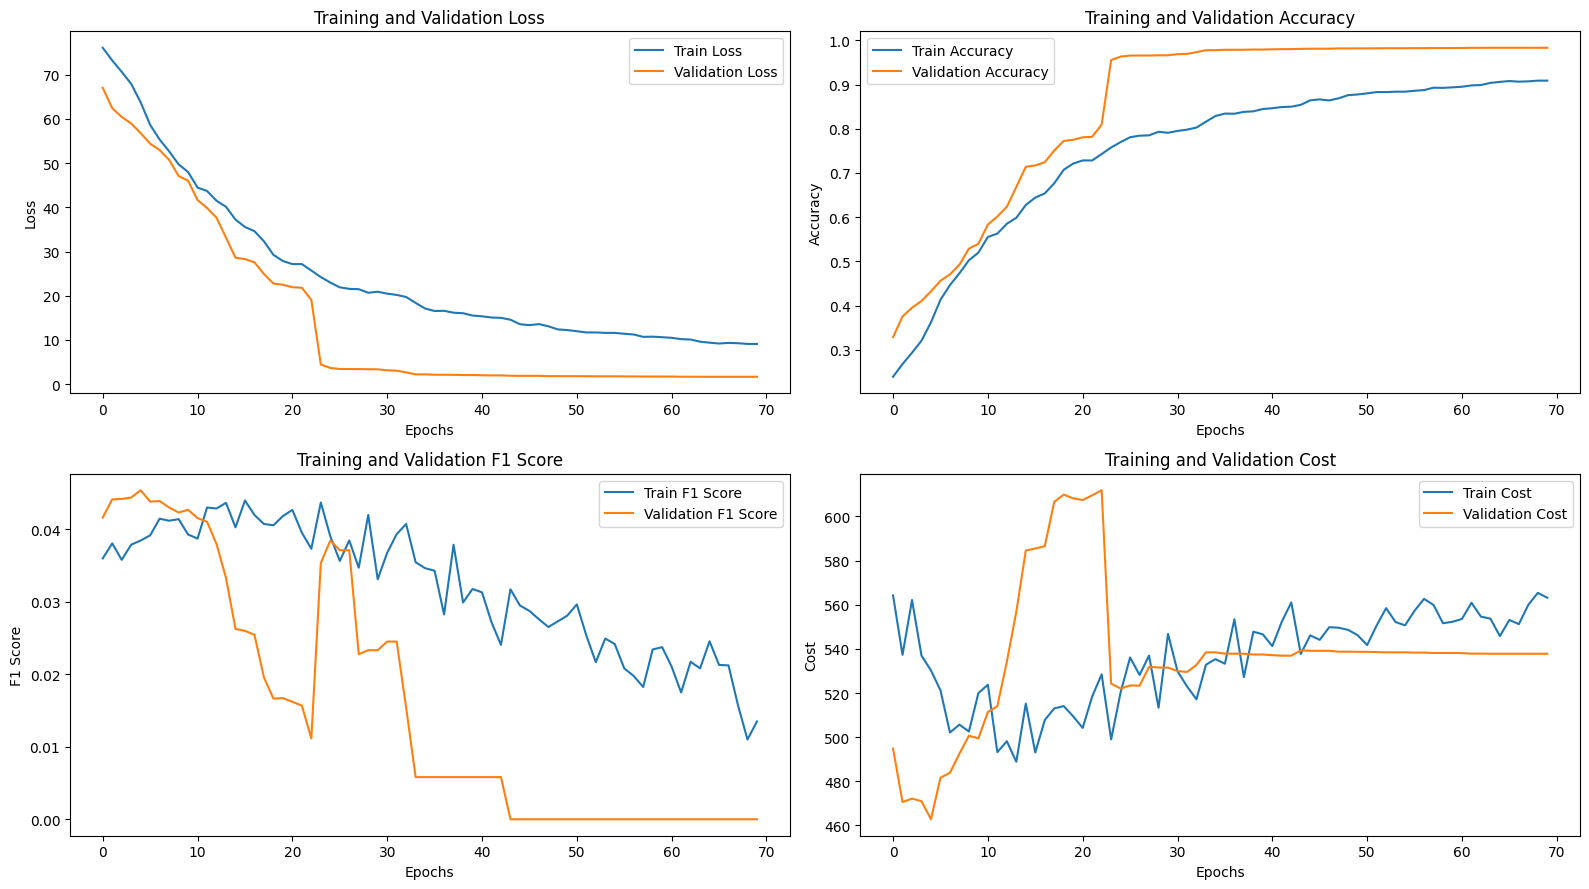

In [157]:
plot_training_history(train_loss_history, train_acc_history, train_f1_history, train_cost_history, 
                      valid_loss_history, valid_acc_history, valid_f1_history, valid_cost_history)

에러 수정 기록
1. RuntimeError: "nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Float' : [티스토리](https://data-science.tistory.com/170)
2. RuntimeError: CUDA error: device-side assert triggered : [티스토리](https://wsshin.tistory.com/12)